<a href="https://colab.research.google.com/github/Vamsi995/Paraphrase-Generator/blob/master/Paraphrase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Inferential Transformer: Semantic Alignment Generation from Pre-trained Generative Model**

### **What models can be used**


### T5 (Encoder decoder transformer)


  T5 (*Text-to-text Transfer Transformer*) is yet another transformer model for Google Research Group. This is a vanilla transformer i.e this model has both the encoder and decoder layers as described in the paper [ Attention is All You Need](https://arxiv.org/abs/1706.03762). T5 is a encoder-decoder model that reaches SOTA results by solving NLP problems with a text-to-text approach. This is where text is used as both an input and an output for solving all types of tasks. This was introduced in the recent paper, Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer ([paper](https://arxiv.org/abs/1910.10683)).

  ![](https://1.bp.blogspot.com/-89OY3FjN0N0/XlQl4PEYGsI/AAAAAAAAFW4/knj8HFuo48cUFlwCHuU5feQ7yxfsewcAwCLcBGAsYHQ/s640/image2.png)

  As we can see from the above picture, we have prepend our task name in front of the input and pass it to the model. If we want to fine tune our model to a specific task then our inputs should be modified to "task_name: input_sentence < /s> " and the output should be modified to "output_sentence < /s>". This model then can be trained on this modified input and output sequences.



To explore this model:

1. [T5 Paper](https://arxiv.org/abs/1910.10683)

2. [A Brief Paper Analysis](https://towardsdatascience.com/t5-text-to-text-transformer-a-brief-paper-analysis-e4bba797bd68)

3. [Exploring Transfer Learning with T5: the Text-To-Text Transfer Transformer](https://ai.googleblog.com/2020/02/exploring-transfer-learning-with-t5.html)

4. [Collin Rafel's Talk](https://www.youtube.com/watch?v=eKqWC577WlI)

### Bart (Encoder decoder transformer)

This is similar to the T5 model. This was released by the Facebook's AI team. To explore more about this model I suggest you to go through these links:

1. [Blog Post](https://mc.ai/introducing-bart-combining-the-power-of-bert-and-gpt/)

2. [Introducing BART](https://sshleifer.github.io/blog_v2/jupyter/2020/03/12/bart.html)

3. [BART Paper](https://www.aclweb.org/anthology/2020.acl-main.703.pdf)

4. [Hugging Face Docs](https://huggingface.co/transformers/model_doc/bart.html)

### Transformer + seq2seq model

  The output from encoder models like BERT, is fed in to a seq2seq encoder-decoder model. To explore this model in detail read through the [paper](https://www.aclweb.org/anthology/D19-5627.pdf).



### Encoder-Decoder model

  In this model, one BERT model is used as the encoder and the other BERT model is used as a decoder. Hugging face has a method to implement this model using the Encoder-Decoder Class where we can instantiate one model as an encoder and any other model as a decoder. As of now only the support of BERT2BERT models exist. You can head to the [docs](https://huggingface.co/transformers/model_doc/encoderdecoder.html) for futher implementation details. Do note that there is no Tensorflow implementation of this Encoder-Decoder class as of now only the Pytorch bindings exist.






### **Building the T5 model for fine tuning**

#### **Set Up Environemnt and Seed**

In [1]:
import os
import argparse
import torch
import logging 
import pandas as pd
import pytorch_lightning as pl

from transformers import AdamW, T5ForConditionalGeneration, T5Tokenizer, get_linear_schedule_with_warmup
from saint.dataset.multi_task_dataset import MultiTaskDataset
from saint.utils.utils import set_seed

logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
logger = logging.getLogger(__name__)

set_seed(42)

#### **Prepare Few-shot Dataset**

In [ ]:
from saint.utils import py_io

train_raw_data = py_io.read_jsonl("./train_snli.jsonl")
val_raw_data = py_io.read_jsonl("./test_snli.jsonl")

label_2_answer = {
    "entailment": "correct",
    "contradiction": "incorrect",
    "neutral": "inconclusive"
}

train_data_nli = []
val_data_nli = []
train_data_evid = []
val_data_evid = []
train_data_enli = []
val_data_enli = []

def build_data_instance(data):
    premise = data['premise']
    hypothesis = data['hypothesis']
    label = data['gold_label']
    answer = label_2_answer[label]

    evidence = [f"{pair[0]}->{pair[1]}" for pair in zip(data['Evidence1'], data['Evidence2'])]

    nli_prompt = f"nli: Given \"{premise}\" We should assume that " + \
        f"\"{hypothesis}\" is definitely definitely correct, incorrect, or inconclusive?"
    evid_prompt = f"List evidence: Given \"{premise}\" We should assume that " + \
        f"\"{hypothesis}\" is definitely {answer} What is the evidence?"
    enli_prompt = f"Given \"{premise}\" We should assume that " + \
        f"\"{hypothesis}\" is definitely correct, incorrect, or inconclusive? List evidence"

    nli_example = {
        "prompt": nli_prompt,
        "output": answer,
    }

    evid_example = {
        "prompt": evid_prompt,
        "output": "; ".join(evidence)
    }

    enli_example = {
        "prompt": enli_prompt,
        "output": f"{answer} supported by this list of evidence: " + "; ".join(evidence)
    }
    
    return nli_example, evid_example, enli_example

def write_all_input_data(task):
    py_io.write_jsonl(train_data_nli, f"data/{task}/nli_train.jsonl")
    py_io.write_jsonl(train_data_evid, f"data/{task}/evid_train.jsonl")
    py_io.write_jsonl(train_data_enli, f"data/{task}/enli_train.jsonl")
    py_io.write_jsonl(val_data_nli, f"data/{task}/nli_val.jsonl")
    py_io.write_jsonl(val_data_evid, f"data/{task}/evid_val.jsonl")
    py_io.write_jsonl(val_data_enli, f"data/{task}/enli_val.jsonl")

for data in train_raw_data:
    nli_example, evid_example, enli_example = build_data_instance(data)
    train_data_nli.append(nli_example)
    train_data_evid.append(evid_example)
    train_data_enli.append(enli_example)

for data in val_raw_data:
    nli_example, evid_example, enli_example = build_data_instance(data)
    val_data_nli.append(nli_example)
    val_data_evid.append(evid_example)
    val_data_enli.append(enli_example)

write_all_input_data("snli")

#### **Multi-task Dataset Setup**

In [2]:
import os
import copy
import re
import string
import torch
import numpy as np
import saint.utils.py_io as py_io

from collections import Counter
from torch.utils.data import (
    Dataset,
    DataLoader,
    RandomSampler,
    SequentialSampler
)


class QADataset(Dataset):
    def __init__(self, inputs_tokenized, outputs_tokenized):
        
        self.inputs_tokenized = inputs_tokenized
        self.outputs_tokenized = outputs_tokenized

    def __len__(self):
        return len(self.inputs_tokenized)

    def __getitem__(self, index):
        source_ids = self.inputs_tokenized[index]["input_ids"].squeeze()
        target_ids = self.outputs_tokenized[index]["input_ids"].squeeze()

        src_mask = self.inputs_tokenized[index]["attention_mask"].squeeze()
        target_mask = self.outputs_tokenized[index]["attention_mask"].squeeze()

        labels = copy.deepcopy(target_ids)
        labels[labels == 0] = -100

        return {
            "source_ids": source_ids,
            "source_mask": src_mask,
            "target_ids": target_ids,
            "target_mask": target_mask,
            "labels": labels
        }


class MultiTaskDataLoader(DataLoader):
    def __init__(self, dataset, is_training, 
                 train_batch_size, val_batch_size):
        if is_training:
            sampler = RandomSampler(dataset)
            batch_size = train_batch_size
        else:
            sampler = SequentialSampler(dataset)
            batch_size = val_batch_size
        super(MultiTaskDataLoader, self).__init__(
            dataset, sampler=sampler, batch_size=batch_size)


class MultiTaskDataset:

    def __init__(self, logger, data_path, tasks, data_split, train_batch_size, val_batch_size, is_training):
        self.data_path = data_path
        self.data = []

        for task in sorted(tasks):
            task_dir = os.path.join(self.data_path, task)
            
            prefixes = ["nli", "evid"]

            for prefix in prefixes:
                train_file_pth = os.path.join(
                    task_dir, f"{prefix}_train.jsonl")
                train_examples = py_io.read_jsonl(path=train_file_pth)

                dev_file_pth = os.path.join(
                    task_dir, f"{prefix}_val.jsonl")
                dev_examples = py_io.read_jsonl(path=dev_file_pth)

                self.data.append({
                    "task_name": task,
                    "task_prefix": prefix,
                    "train_examples": train_examples,
                    "dev_examples": dev_examples
                })

        self.data_split = data_split
        self.is_training = is_training
        self.logger = logger

        self.metric = "EM"
        self.tokenizer = None
        self.dataset = None
        self.dataloader = None
        self.cache = None
        self.load = True
        self.gen_early_stop = False
        self.max_len_input = 128
        self.max_len_output = 128
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size

    def __len__(self):
        return len(self.data)

    def decode(self, tokens):
        return self.tokenizer.decode(tokens, skip_special_tokens=True, clean_up_tokenization_spaces=True)

    def decode_batch(self, tokens):
        return [self.decode(_tokens) for _tokens in tokens]

    def _build_cache_path(self, tokenizer):
        postfix = tokenizer.__class__.__name__.replace("zer", "zed")
        return os.path.join(
            self.data_path,
            f"{self.data_split}-multi-{postfix}.pt"
        )

    def load_dataset(self, tokenizer, do_return=False):
        self.tokenizer = tokenizer
        preprocessed_path = self._build_cache_path(tokenizer)

        if self.load and os.path.exists(preprocessed_path):
            self.logger.info(
                f"Loading pre-tokenized data from {preprocessed_path}")
            tokenized = torch.load(preprocessed_path)
            inputs_tokenized = tokenized["inputs_tokenized"]
            outputs_tokenized = tokenized["outputs_tokenized"]
        else:
            self.logger.info(
                f"Start tokenizing ... {len(self.data)} instances")

            inputs = []
            outputs = []
            inputs_tokenized = []
            outputs_tokenized = []

            for task in self.data:
                if self.data_split in ["train", "all"]:
                    for dp in task["train_examples"]:
                        inputs.append(dp["prompt"])
                        outputs.append(dp["output"])
                if self.data_split in ["val", "all"]:
                    for dp in task["dev_examples"]:
                        inputs.append(dp["prompt"])
                        outputs.append(dp["output"])

            self.logger.info("Printing 3 examples")
            for i in range(3):
                self.logger.info(inputs[i])
                self.logger.info(outputs[i])

            # if self.args.do_lowercase:
            #     inputs = [input0.lower() for input0 in inputs]
            #     outputs = [output0.lower() for output0 in outputs]
            # if self.args.append_another_bos:
            #     inputs = [f"<s> {input0}" for input0 in inputs]
            #     outputs = [f"<s> {output0}" for output0 in outputs]

            self.logger.info("Tokenizing data points ...")
            for prompt, output in zip(inputs, outputs):
                tokenized_inputs = self.tokenizer.batch_encode_plus(
                    [prompt], 
                    max_length=self.max_len_input, 
                    pad_to_max_length=True, 
                    return_tensors="pt"
                )

                tokenized_targets = self.tokenizer.batch_encode_plus(
                    [output], 
                    max_length=self.max_len_output, 
                    pad_to_max_length=True, 
                    return_tensors="pt"
                )

                inputs_tokenized.append(tokenized_inputs)
                outputs_tokenized.append(tokenized_targets)

            if self.load:
                preprocessed_data = {
                    "inputs_tokenized": inputs_tokenized,
                    "outputs_tokenized": outputs_tokenized
                }
                torch.save(preprocessed_data, preprocessed_path)

        self.dataset = QADataset(inputs_tokenized, outputs_tokenized)
        self.logger.info(
            f"Loaded {len(self.dataset)} examples from {self.data_split} data")

        if do_return:
            return self.dataset

    def load_dataloader(self, do_return=False):
        self.dataloader = MultiTaskDataLoader(
            self.dataset, self.is_training,
            self.train_batch_size, self.val_batch_size
        )
        if do_return:
            return self.dataloader

    def save_predictions(self, predictions):
        assert len(predictions) == len(self), (len(predictions), len(self))

        predictions = [
            'n/a' if len(prediction.strip()) ==
            0 else prediction for prediction in predictions
        ]
        prediction_text = [
            prediction.strip()+'\n' for prediction in predictions]
        save_path = os.path.join(
            self.output_dir,
            f"{self.prefix}_predictions.txt")
        with open(save_path, "w") as f:
            f.writelines(prediction_text)

        self.logger.info(f"Saved prediction in {save_path}")

In [5]:
#from saint.multi_task_dataset import MultiTaskDataset

model_name_or_path = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_name_or_path)

data_dir = "data"

train_multi_data = MultiTaskDataset(
    logger, data_path=data_dir, 
    tasks=["snli"], data_split="train", 
    train_batch_size=2, val_batch_size=2,
    is_training=True)
dev_multi_data = MultiTaskDataset(
    logger, data_path=data_dir, 
    tasks=["snli"], data_split="val",
    train_batch_size=2, val_batch_size=2, 
    is_training=False)

train_multi_data.load_dataset(tokenizer)
train_multi_data.load_dataloader()

dev_multi_data.load_dataset(tokenizer)
dev_multi_data.load_dataloader()

03/06/2022 13:48:13 - INFO - __main__ - Start tokenizing ... 2 instances
03/06/2022 13:48:13 - INFO - __main__ - Printing 3 examples
03/06/2022 13:48:13 - INFO - __main__ - nli: Given "A person dressed in a coat and hat holds a tray on his bicycle." We should assume that "A person is travelling" is definitely definitely correct, incorrect, or inconclusive?
03/06/2022 13:48:13 - INFO - __main__ - inconclusive
03/06/2022 13:48:13 - INFO - __main__ - nli: Given "A man in a helmet is riding a bike." We should assume that "The man in a helmet is riding a sports bike." is definitely definitely correct, incorrect, or inconclusive?
03/06/2022 13:48:13 - INFO - __main__ - inconclusive
03/06/2022 13:48:13 - INFO - __main__ - nli: Given "Two workers are cleaning a window with bystanders and a dog in the background." We should assume that "A dog plays fetch near two workers." is definitely definitely correct, incorrect, or inconclusive?
03/06/2022 13:48:13 - INFO - __main__ - inconclusive
03/06/20

#### **Create Fine-tuner and Model**

In [6]:
class MetricsCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_end(self, trainer, pl_module):
        self.metrics.append(trainer.callback_metrics)

class T5FineTuner(pl.LightningModule):
    def __init__(self, args, train_dataset, val_dataset):
        super(T5FineTuner, self).__init__()
        self.save_hyperparameters(args)
        self.args = args
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.tokenizer = T5Tokenizer.from_pretrained(
            args.model_name_or_path)
        self.model = T5ForConditionalGeneration.from_pretrained(
            args.model_name_or_path)
        

    def forward(self, input_ids,
                attention_mask=None,
                decoder_input_ids=None,
                decoder_attention_mask=None,
                lm_labels=None):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=decoder_attention_mask,
            labels=lm_labels,
        )

        return outputs

    def training_step(self, batch, batch_idx):
        outputs = self.forward(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            decoder_input_ids = batch["target_ids"],
            decoder_attention_mask=batch["target_mask"],
            lm_labels=batch["labels"]
        )

        loss = outputs[0]
        self.log('train_loss',loss)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self.forward(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            decoder_input_ids = batch["target_ids"],
            decoder_attention_mask=batch["target_mask"],
            lm_labels=batch["labels"]
        )

        loss = outputs[0]
        self.log("val_loss",loss)
        return loss

    def save_core_model(self):
        store_path = os.path.join(
            self.args.output_dir,
            self.args.name)
        self.model.save_pretrained(store_path)
        self.tokenizer.save_pretrained(store_path)

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.hparams.lr, eps=1e-8)
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=self.hparams.warmup_steps,
            num_training_steps=self.hparams.max_epochs * len(self.train_dataset))
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

    def train_dataloader(self):
        return self.train_dataset.dataloader

    def val_dataloader(self):
        return self.val_dataset.dataloader

### **Fine-tune Your Own Inferential T5**

#### **Initialize Hyperparameters and Training Arguments**

In [7]:
import argparse

trial_number = 1

args_dict = dict(
    name="snli-evidence-t5-base",
    data_dir="",
    output_dir="./runs",
    model_name_or_path='t5-base',
    max_seq_length=512,
    lr=3e-5,
    weight_decay=0.0,
    warmup_steps=0,
    train_batch_size=2,
    eval_batch_size=2,
    max_epochs=7,
    gradient_accumulation_steps=16,
    n_gpu=1,
    fp_16=False,
    opt_level='O1',
    max_grad_norm=1.0,
    seed=42,
)

args = argparse.Namespace(**args_dict)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=os.path.join(args.output_dir, args.name),
    filename="checkpoint_best",
    monitor="val_loss",
    mode="min",
    save_top_k=2
)

metrics_callback = MetricsCallback()

train_params = dict(
    #accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.max_epochs,
    progress_bar_refresh_rate=10,
    #precision= 16 if args.fp_16 else 32,
    #amp_level=args.opt_level,
    #gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=True,
    callbacks=[metrics_callback, checkpoint_callback]
)

#### **Run Training and Validation Loop**

In [8]:
import warnings
warnings.filterwarnings('ignore')

model = T5FineTuner(args, train_dataset=train_multi_data, val_dataset=dev_multi_data)
trainer = pl.Trainer(**train_params)

print (" Training model")
trainer.fit(model)
#trainer.test(model)

print ("Saving model ... ")
model.save_core_model()

print("Model Saved")
print(checkpoint_callback.best_model_path)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


 Training model



  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Epoch 6: 100%|██████████| 399/399 [00:38<00:00, 10.29it/s, loss=0.328, v_num=13]
Saving model ... 
Model Saved
C:\Users\Admin\Desktop\Research-spring-2022\ultralog\runs\snli-evidence-t5-base\checkpoint_best.ckpt


#### **Test On Validation Set**

In [12]:
from tqdm import tqdm
from saint.utils.metric import (
    compute_f1,
    compute_rouge,
    compute_bleu_score,
    compute_exact_match
)

import torch

from transformers import T5ForConditionalGeneration, T5Tokenizer

class T5AlignmentGenerator:

    def __init__(self, model, test_data):
        self.model = T5ForConditionalGeneration.from_pretrained(model)
        self.tokenizer = T5Tokenizer.from_pretrained(model)

        self.model.eval()
        self.model.cuda()

        self.test_data = test_data

    def _tokenization(self, sentences):
        tokenized = self.tokenizer.encode_plus(
            sentences, return_tensors="pt")
        tokenized.to('cuda')

        input_ids = tokenized["input_ids"]
        attention_mask = tokenized["attention_mask"]
        return input_ids, attention_mask

    def generate(self):
        generation_output = []
        with torch.no_grad():
            for _, test_example in tqdm(enumerate(self.test_data)):
                prompt = test_example['input']
                target = test_example["output"]
                input_ids, attention_mask = self._tokenization(prompt)

                beam_outputs = self.model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_length=50,
                    num_beams=10,
                    top_k=10,
                    do_sample=True,
                    early_stopping=True,
                    num_return_sequences=5,
                    no_repeat_ngram_size=2
                )

                for beam_output in beam_outputs:
                    prediction = self.tokenizer.decode(
                        beam_output,
                        skip_special_tokens=True,
                        clean_up__tokenization_spaces=True)
                    f1_score = compute_f1(prediction, target)
                    em_score = compute_exact_match(prediction, target)
                    rouge_scores = compute_rouge(prediction, target)
                    bleu_score = compute_bleu_score(prediction, target)

                    result = {
                        "prompt": prompt,
                        "prediction": prediction,
                        "truth": target,
                        "F1": f1_score,
                        "EM": em_score,
                        "BLEU-4": bleu_score,
                        "ROUGEL": rouge_scores['rougeL'][1],
                    }
                    generation_output.append(result)
                    if rouge_scores['rougeL'][1] == 1:
                        break
        return generation_output

In [13]:
from saint.utils import py_io

dataset = "causal_snli"
task = "causal_snli_entail"

test_data = py_io.read_jsonl(f"data/{dataset}/{task}/dev.jsonl")
t5_saint_generator = T5AlignmentGenerator("allenai/unifiedqa-t5-small", test_data)
alignment_output = t5_saint_generator.generate()

1it [00:06,  6.83s/it]c:\Users\Admin\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Admin\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
42it [00:14,  6.82it/s]c:\Users\Admin\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-g

In [15]:
len(alignment_output)

375

In [29]:
from saint.utils.py_io import read_json

relational_pred = alignment_output
rougeL_recall_sum = 0
for i in range(0, len(relational_pred)-5, 5):
  r1 = relational_pred[i]['ROUGEL']
  r2 = relational_pred[i+1]['ROUGEL']
  r3 = relational_pred[i+2]['ROUGEL']
  r4 = relational_pred[i+3]['ROUGEL']
  r5 = relational_pred[i+4]['ROUGEL']
  rougeL_recall_sum += max(r1, r2, r3, r4, r5)
avg_rougeL_recall = rougeL_recall_sum / (len(relational_pred) / 5)

bleu_sum = 0
for i in range(0, len(relational_pred)-5, 5):
  r1 = relational_pred[i]['BLEU-4']
  r2 = relational_pred[i+1]['BLEU-4']
  r3 = relational_pred[i+2]['BLEU-4']
  r4 = relational_pred[i+3]['BLEU-4']
  r5 = relational_pred[i+4]['BLEU-4']
  bleu_sum += max(r1, r2, r3, r4, r5)
avg_bleu = bleu_sum / (len(relational_pred) / 5)

{
  'avg_bleu': avg_bleu,
  'avg_rougeL_recall': avg_rougeL_recall
}

{'avg_bleu': 0.4145414735197152, 'avg_rougeL_recall': 0.3281853281853282}

In [ ]:
relational_pred = read_json("relational_pred.json")

rougeL_recall_sum = 0
for i in range(0, len(relational_pred)-5, 5):
  r1 = relational_pred[i]['ROUGEL']
  r2 = relational_pred[i+1]['ROUGEL']
  r3 = relational_pred[i+2]['ROUGEL']
  r4 = relational_pred[i+3]['ROUGEL']
  r5 = relational_pred[i+4]['ROUGEL']
  rougeL_recall_sum += max(r1, r2, r3, r4, r5)
avg_rougeL_recall = rougeL_recall_sum / (len(relational_pred) / 5)

bleu_sum = 0
for i in range(0, len(relational_pred)-5, 5):
  r1 = relational_pred[i]['BLEU-4']
  r2 = relational_pred[i+1]['BLEU-4']
  r3 = relational_pred[i+2]['BLEU-4']
  r4 = relational_pred[i+3]['BLEU-4']
  r5 = relational_pred[i+4]['BLEU-4']
  bleu_sum += max(r1, r2, r3, r4, r5)
avg_bleu = bleu_sum / (len(relational_pred) / 5)

{
  'avg_bleu': avg_bleu,
  'avg_rougeL_recall': avg_rougeL_recall
}

In [ ]:
ret_val = [{
    "premise": "Herceptin was already approved to treat the sickest breast cancer patients, and the company said, Monday, it will discuss with federal regulators the possibility of prescribing the drug for more breast cancer patients.", 
    "source": "Herceptin is used to treat breast cancer",
    "target": "Herceptin was already approved to treat the sickest breast cancer patients",
  },
  {
    "premise": "Herceptin was already approved to treat the sickest breast cancer patients, and the company said, Monday, it will discuss with federal regulators the possibility of prescribing the drug for more breast cancer patients.", 
    "source": "more breast cancer patients may get prescription of Herceptin",
    "target": "the possibility of prescribing the drug for more breast cancer patients",
  },
  {
    "premise": "Judie Vivian, chief executive at ProMedica, a medical service company that helps sustain the 2-year-old Vietnam Heart Institute in Ho Chi Minh City (formerly Saigon), said that so far about 1,500 children have received treatment.",
    "source": "The previous name of Ho Chi Minh City was Saigon.",
    "target": "Ho Chi Minh City (formerly Saigon)",
  }
]

In [ ]:
premise = ret_val[0]['premise']
source = ret_val[0]['source']
target = ret_val[0]["target"]

test_sent = f"Premise: {premise} <extra_id_0> Source Phrase: {source} <extra_id_1> In Premise , Source Phrase aligns to: </s>"
test_tokenized = infer_model.tokenizer.encode_plus(test_sent, return_tensors="pt")

test_input_ids  = test_tokenized["input_ids"]
test_attention_mask = test_tokenized["attention_mask"]

infer_model.model.eval()
beam_outputs = infer_model.model.generate(
    input_ids=test_input_ids,
    attention_mask=test_attention_mask,
    max_length=64,
    early_stopping=True,
    num_beams=10,
    num_return_sequences=3,
    no_repeat_ngram_size=2
)

print("premise: " + premise)
print("source: " + source)
print("target: " + target)

print("Predictions: ")
for beam_output in beam_outputs:
    sent = infer_model.tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
    print (sent)

In [ ]:
premise = ret_val[1]['premise']
source = ret_val[1]['source']
target = "the company said, Monday, it will discuss with federal regulators"
source = "the company and federal regulators will have a discussion"

test_sent = f"Premise: {premise} <extra_id_0> Source Phrase: {source} <extra_id_1> In Premise , Source Phrase aligns to: </s>"
test_tokenized = infer_model.tokenizer.encode_plus(test_sent, return_tensors="pt")

test_input_ids  = test_tokenized["input_ids"]
test_attention_mask = test_tokenized["attention_mask"]

infer_model.model.eval()
beam_outputs = infer_model.model.generate(
    input_ids=test_input_ids,
    attention_mask=test_attention_mask,
    max_length=20,
    early_stopping=True,
    num_beams=10,
    num_return_sequences=3,
    no_repeat_ngram_size=2
)

print("premise: " + premise)
print("source: " + source)
print("target: " + target)

print("Predictions: ")
for beam_output in beam_outputs:
    sent = infer_model.tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
    print (sent)

In [ ]:
premise = ret_val[2]['premise']
source = ret_val[2]['source']
target = ret_val[2]["target"]

test_sent = f"Premise: {premise} <extra_id_0> Source Phrase: {source} <extra_id_1> In Premise , Source Phrase aligns to: </s>"
test_tokenized = infer_model.tokenizer.encode_plus(test_sent, return_tensors="pt")

test_input_ids  = test_tokenized["input_ids"]
test_attention_mask = test_tokenized["attention_mask"]

infer_model.model.eval()
beam_outputs = infer_model.model.generate(
    input_ids=test_input_ids,
    attention_mask=test_attention_mask,
    max_length=20,
    early_stopping=True,
    num_beams=10,
    num_return_sequences=3,
    no_repeat_ngram_size=2
)

print("premise: " + premise)
print("source: " + source)
print("target: " + target)

print("Predictions: ")
for beam_output in beam_outputs:
    sent = infer_model.tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
    print (sent)

In [1]:
from saint.eval.auto_eval.ctc_scorer.bert_aligner import BERTAligner, E_MODEL_CONFIGS

aligner = BERTAligner(
    **E_MODEL_CONFIGS["roberta-mnli"],
    aggr_type="mean",
    lang="en"
)

c:\Users\Admin\anaconda3\envs\causal_lens\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaModel: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
sim_matrix, sent1_toks, sent2_toks = aligner.get_sim_matrix(candidate="A person on a horse jumps over a broken down airplane",
                  reference="A person is at a diner ordering an omelette")
sent2_toks

['A',
 ' person',
 ' on',
 ' a',
 ' horse',
 ' jumps',
 ' over',
 ' a',
 ' broken',
 ' down',
 ' airplane']

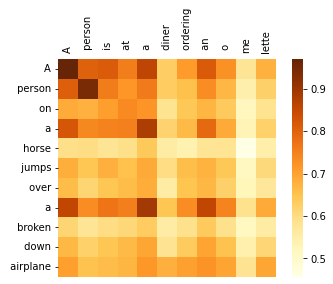

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.tick_params(labelbottom = False, bottom=False, top=False, labeltop=True)
plt.xticks(rotation=0)
plt.yticks(rotation=90)

ax = sns.heatmap(
    sim_matrix.detach().cpu().numpy(),
    xticklabels=sent1_toks,
    yticklabels=sent2_toks,
    cmap="YlOrBr",
    square=True,
)